# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.
#### Contributors
- Pradeep Kumar S (Group Facilitator)
- Manoj Romina

In [1]:
# downgrading scipy to access imresize and imread methods
!pip install scipy==1.1

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
from scipy.misc import imread, imresize
import numpy as np
import datetime
import warnings
import abc
import os

# turning off warnings generated during model run
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten
from keras.layers import BatchNormalization, Activation, Dropout, ZeroPadding3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import optimizers
from keras.layers.recurrent import LSTM

In [4]:
# visualization and augmentation packages
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [5]:
# setting seeds for results reproducability
np.random.seed(30)

import random as rn
rn.seed(30)

from tensorflow import keras
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [6]:
# Defining the path for train and test images
project_folder = '/home/datasets/Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class BaseModelBuilder(metaclass=abc.ABCMeta):
    """Base Model builder class"""
    def __init__(self, image_height=120, image_width=120):
        self.image_height = image_height
        self.image_width = image_width
        self.num_channels = 3
        self.num_classes = 5
        self.total_frames = 30
        self.tensor3d = (self.image_height, self.image_width, self.num_channels)

    def initialize_project_path(self, project_folder):
        """Method to initiale project path to the model"""
        self.train_doc = np.random.permutation(
            open(project_folder + '/train.csv').readlines()
        )
        self.val_doc = np.random.permutation(
            open(project_folder + '/val.csv').readlines()
        )
        self.train_path = project_folder + '/train'
        self.val_path = project_folder + '/val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def tune_hyper_parameters(self, epochs=20, batch_size=20, sample_frames=30):
        """Method to tune the hyperparameters of the model"""
        self.frames_to_sample = sample_frames
        self.num_epochs = epochs
        self.batch_size = batch_size

    def __show_param_details__(self):
        """Method to print model input parameters"""
        print(' Project Folder '.center(50, '='), '\n')
        print('# training sequences =', len(self.train_doc))
        print('# validation sequences =', len(self.val_doc), '\n')
        print(' Image Properties '.center(50, '='), '\n')
        print('# Image Height =', self.image_height)
        print('# Image Width =', self.image_width)
        print('# Channels =', self.num_channels)
        print('# Output Classes =', self.num_classes)
        print('# Total Frames =', self.total_frames, '\n') 
        print(' Hyperparameters '.center(50, '='), '\n')
        print('# Number of Frames to sample =', self.frames_to_sample)
        print('# epochs =', self.num_epochs)
        print('# Batch Size =', self.batch_size)
        print('# 3D Tensor =', self.tensor3d)

    def __build_batch(self, source_path, t, batch, batch_size, img_idx, 
                      augmentation, remaining_seq=0):
        """Method to build a batch based on parameters passes"""
        # checking if the remaining sequence is passes else assign batch size
        sequence_length = remaining_seq if remaining_seq else batch_size
        # x is the number of images you use for each video, (y,z) is the 
        # final size of the input images and 3 is the number of channels RGB
        batch_data = np.zeros(
            (sequence_length, len(img_idx), self.image_height, 
             self.image_width, self.num_channels)
        )
        # batch_labels is the one hot representation of the output
        batch_labels = np.zeros((sequence_length, self.num_classes))

        if augmentation:
            aug_batch_data = np.zeros(
                (sequence_length, len(img_idx), self.image_height, 
                self.image_width, self.num_channels)
            )

        # iterate over the batch_size (sequence_length)
        for folder in range(sequence_length):
            # read all the images in the folder
            imgs = os.listdir(
                source_path + '/' + t[folder + (batch*batch_size)].split(';')[0]
            )
            # Iterate over the frames/images of a folder to read them in
            for idx, item in enumerate(img_idx):
                image = imread(
                    source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]
                ).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                img_resized = imresize(image, self.tensor3d)
                # normalise image for RGB
                batch_data[folder,idx,:,:,0] = img_resized[:,:,0] / 255
                batch_data[folder,idx,:,:,1] = img_resized[:,:,1] / 255
                batch_data[folder,idx,:,:,2] = img_resized[:,:,2] / 255

                if augmentation:
                    shifted_image = cv2.warpAffine(
                        image, np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), 
                        (image.shape[1], image.shape[0])
                    )
                    gray = cv2.cvtColor(shifted_image, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped_image = shifted_image[x0:x1, y0:y1, :]

                    img_resized = imresize(cropped_image, self.tensor3d)
                    aug_batch_data[folder,idx,:,:,0] = img_resized[:,:,0] / 255
                    aug_batch_data[folder,idx,:,:,1] = img_resized[:,:,1] / 255
                    aug_batch_data[folder,idx,:,:,2] = img_resized[:,:,2] / 255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        if augmentation:
            batch_data = np.concatenate([batch_data, aug_batch_data])
            batch_labels = np.concatenate([batch_labels, batch_labels])
        return batch_data, batch_labels

    def __generator(self, source_path, folder_list, batch_size, augmentation=False):
        """Generator Method to generate batches of data"""
        # create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)

        while True:
            t = np.random.permutation(folder_list)

            # calculate the number of batches
            num_batches = len(t) // batch_size
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels = self.__build_batch(
                    source_path, t, batch, batch_size, img_idx, augmentation
                )
                yield batch_data, batch_labels
            
            # code for the remaining data points which are left after full batches
            remaining_sequences = len(t) % batch_size
            if remaining_sequences != 0:
                batch_data, batch_labels = self.__build_batch(
                    source_path, t, num_batches, batch_size, img_idx, 
                    augmentation, remaining_sequences
                )
                yield batch_data, batch_labels 

    def compile_model(self, model, optimizer=optimizers.Adam()):
        """Method to compile a model"""
        model.compile(
            optimizer=optimizer, loss='categorical_crossentropy', 
            metrics=['categorical_accuracy']
        )
    
    def train_model(self, model, augment_data=False):
        """Method to train a model"""
        train_generator = self.__generator(
            self.train_path, self.train_doc, self.batch_size, augment_data
        )
        val_generator = self.__generator(self.val_path, self.val_doc, self.batch_size)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
                
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        checkpoint = ModelCheckpoint(
            filepath, monitor='val_loss', verbose=1, save_best_only=True, 
            save_weights_only=False, mode='auto', period=1
        )
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if self.num_train_sequences % self.batch_size == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if self.num_val_sequences % self.batch_size == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1
        
        model_history = model.fit_generator(
            train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, 
            verbose=1, callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, 
            initial_epoch=0
        )
        return model_history

    def plot_model_results(self, history):
        """Method to plot the model performance parameters"""
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(self.num_epochs)

        plt.figure(figsize=(18, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Categorical Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    @abc.abstractmethod
    def construct_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.
### 3D Convolution (Conv3D) Model
#### Base Model
Creating a Base Model with 30 batches of data and 15 epochs without resizing images and no sampling (use all frames).

In [8]:
class Conv3DModelBase(BaseModelBuilder):
    """First/Base 3D convolution model"""
    def construct_model(self, filter_size=(3,3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(Conv3D(16, filter_size, input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        ), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
# creating base model
base_model = Conv3DModelBase(image_height=160, image_width=160)
base_model.initialize_project_path(project_folder)
base_model.tune_hyper_parameters(epochs=10, batch_size=30, sample_frames=30)
base_model.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 160
# Image Width = 160
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 30
# epochs = 10
# Batch Size = 30
# 3D Tensor = (160, 160, 3)


In [10]:
# compile the model and show model summary
conv3d_base_model = base_model.construct_model()
conv3d_base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 40, 40, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 40, 40, 64)     5

Training the model using `.fit_generator`.

In [11]:
# train the model
base_history = base_model.train_model(model=conv3d_base_model)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.9017 - categorical_accuracy: 0.2293
Epoch 00001: val_loss improved from inf to 1.58590, saving model to model_init_2021-05-3006_25_19.271515/model-00001-1.90166-0.22926-1.58590-0.47000.h5
23/23 [==============================] - 96s 4s/step - loss: 1.9017 - categorical_accuracy: 0.2293 - val_loss: 1.5859 - val_categorical_accuracy: 0.4700
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.4238 - categorical_accuracy: 0.3816
Epoch 00002: val_loss improved from 1.58590 to 1.12138, saving model to model_init_2021-05-3006_25_19.271515/model-00002-1.42382-0.38160-1.12138-0.54000.h5
23/23 [==============================] - 104s 5s/step - loss: 1.4238 - categorical_accuracy: 0.3816 - val_loss: 1.1214 - val_categorical_accuracy: 0.5400
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.9492 - categorical_accuracy

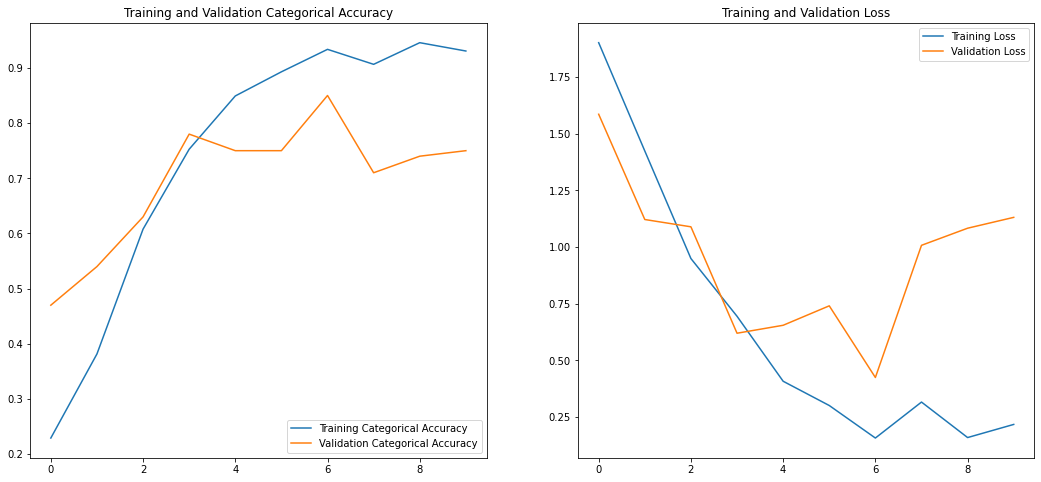

In [12]:
base_model.plot_model_results(base_history)

We can observe that the base model is __overfitting__. We can try out different combinations of image properties, hyperparameter tuning and batch sizes and select those having high impact to the models.
##### Experimenting with Hyperparameters

In [10]:
# Base Model Experiment 1 - sample frames to 16 and batch size 30 and no change in image properties and NO augmentation
conv3d_exp_1 = Conv3DModelBase(image_height=160, image_width=160)
conv3d_exp_1.initialize_project_path(project_folder)
conv3d_exp_1.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=16)
conv3d_exp_model_1 = conv3d_exp_1.construct_model()
conv3d_exp_1.train_model(model=conv3d_exp_model_1)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.7485 - categorical_accuracy: 0.2202
Epoch 00001: val_loss improved from inf to 1.62538, saving model to model_init_2021-05-3113_23_04.216148/model-00001-1.74852-0.22021-1.62538-0.21000.h5
23/23 [==============================] - 59s 3s/step - loss: 1.7485 - categorical_accuracy: 0.2202 - val_loss: 1.6254 - val_categorical_accuracy: 0.2100
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.3588 - categorical_accuracy: 0.4118
Epoch 00002: val_loss improved from 1.62538 to 1.52822, saving model to model_init_2021-05-3113_23_04.216148/model-00002-1.35884-0.41176-1.52822-0.45000.h5
23/23 [==============================] - 57s 2s/step - loss: 1.3588 - categorical_accuracy: 0.4118 - val_loss: 1.5282 - val_categorical_accuracy: 0.4500
Epoch 3/5
22/23 [===========================>..] - ETA: 2s - loss: 1.0455 - categorical_accuracy: 0.5803
Epoch 00003: val_loss improved from 1.52822 to 1.16984, saving model to

In [14]:
# Base Model-A Experiment 2 - batch size 30, Image resized to 120x120, use all frames and NO augmentation
conv3d_exp_2 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_2.initialize_project_path(project_folder)
conv3d_exp_2.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=30)
conv3d_exp_model_2 = conv3d_exp_2.construct_model()
conv3d_exp_2.train_model(model=conv3d_exp_model_2)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 2.0711 - categorical_accuracy: 0.2217
Epoch 00001: val_loss improved from inf to 1.60152, saving model to model_init_2021-05-3006_52_49.080777/model-00001-2.07107-0.22172-1.60152-0.28000.h5
23/23 [==============================] - 81s 4s/step - loss: 2.0711 - categorical_accuracy: 0.2217 - val_loss: 1.6015 - val_categorical_accuracy: 0.2800
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.5993 - categorical_accuracy: 0.2293
Epoch 00002: val_loss did not improve from 1.60152
23/23 [==============================] - 82s 4s/step - loss: 1.5993 - categorical_accuracy: 0.2293 - val_loss: 1.6098 - val_categorical_accuracy: 0.1100
Epoch 3/5
22/23 [===========================>..] - ETA: 2s - loss: 1.5323 - categorical_accuracy: 0.3515
Epoch 00003: val_loss improved from 1.60152 to 1.59175, saving model to model_init_2021-05-3006_52_49.080777/model-00003-1.53012-0.35294-1.59175-0.31000.h5
23/23 [=============

In [15]:
# Base Model Experiment 3 - batch size 30, Image resized to 120x120, use 16 frames and NO augmentation
conv3d_exp_3 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_3.initialize_project_path(project_folder)
conv3d_exp_3.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=16)
conv3d_exp_model_3 = conv3d_exp_3.construct_model()
conv3d_exp_3.train_model(model=conv3d_exp_model_3)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.9721 - categorical_accuracy: 0.2398
Epoch 00001: val_loss improved from inf to 1.59702, saving model to model_init_2021-05-3006_59_49.802540/model-00001-1.97214-0.23982-1.59702-0.37000.h5
23/23 [==============================] - 44s 2s/step - loss: 1.9721 - categorical_accuracy: 0.2398 - val_loss: 1.5970 - val_categorical_accuracy: 0.3700
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.5528 - categorical_accuracy: 0.2609
Epoch 00002: val_loss improved from 1.59702 to 1.41892, saving model to model_init_2021-05-3006_59_49.802540/model-00002-1.55276-0.26094-1.41892-0.39000.h5
23/23 [==============================] - 44s 2s/step - loss: 1.5528 - categorical_accuracy: 0.2609 - val_loss: 1.4189 - val_categorical_accuracy: 0.3900
Epoch 3/5
22/23 [===========================>..] - ETA: 1s - loss: 1.3833 - categorical_accuracy: 0.3818
Epoch 00003: val_loss improved from 1.41892 to 1.41414, saving model to

In [16]:
# Base Model-B Experiment 4 - batch size 30, Image resized to 120x120, use 20 frames and NO augmentation
conv3d_exp_4 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_4.initialize_project_path(project_folder)
conv3d_exp_4.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=20)
conv3d_exp_model_4 = conv3d_exp_4.construct_model()
conv3d_exp_4.train_model(model=conv3d_exp_model_4)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.9189 - categorical_accuracy: 0.2127
Epoch 00001: val_loss improved from inf to 1.60266, saving model to model_init_2021-05-3007_04_05.929729/model-00001-1.91894-0.21267-1.60266-0.18000.h5
23/23 [==============================] - 54s 2s/step - loss: 1.9189 - categorical_accuracy: 0.2127 - val_loss: 1.6027 - val_categorical_accuracy: 0.1800
Epoch 2/5
22/23 [===========================>..] - ETA: 1s - loss: 1.6114 - categorical_accuracy: 0.1894
Epoch 00002: val_loss did not improve from 1.60266
23/23 [==============================] - 54s 2s/step - loss: 1.6114 - categorical_accuracy: 0.1885 - val_loss: 1.6139 - val_categorical_accuracy: 0.1500
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accuracy: 0.2112
Epoch 00003: val_loss did not improve from 1.60266
23/23 [==============================] - 55s 2s/step - loss: 1.6098 - categorical_accuracy: 0.2112 - val_loss: 1.6091 - val_c

In [18]:
# Base Model Experiment 5 - batch size 40, Image resized to 120x120, use 20 frames and NO augmentation
conv3d_exp_5 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_5.initialize_project_path(project_folder)
conv3d_exp_5.tune_hyper_parameters(epochs=5, batch_size=40, sample_frames=20)
conv3d_exp_model_5 = conv3d_exp_5.construct_model()
conv3d_exp_5.train_model(model=conv3d_exp_model_5)

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.6404 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.55351, saving model to model_init_2021-05-3007_12_32.205986/model-00001-1.64037-0.20664-1.55351-0.23000.h5
17/17 [==============================] - 57s 3s/step - loss: 1.6404 - categorical_accuracy: 0.2066 - val_loss: 1.5535 - val_categorical_accuracy: 0.2300
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.3325 - categorical_accuracy: 0.4781
Epoch 00002: val_loss improved from 1.55351 to 1.01396, saving model to model_init_2021-05-3007_12_32.205986/model-00002-1.33250-0.47813-1.01396-0.65000.h5
17/17 [==============================] - 57s 3s/step - loss: 1.3325 - categorical_accuracy: 0.4781 - val_loss: 1.0140 - val_categorical_accuracy: 0.6500
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.8559 - categorical_accuracy: 0.6802
Epoch 00003: val_loss improved from 1.01396 to 0.79631, saving model to

In [19]:
# Base Model-C Experiment 6 - batch size 20, Image resized to 120x120, use 20 frames and NO augmentation
conv3d_exp_6 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_6.initialize_project_path(project_folder)
conv3d_exp_6.tune_hyper_parameters(epochs=5, batch_size=20, sample_frames=20)
conv3d_exp_model_6 = conv3d_exp_6.construct_model()
conv3d_exp_6.train_model(model=conv3d_exp_model_6)

Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.3786 - categorical_accuracy: 0.3575
Epoch 00001: val_loss improved from inf to 1.01246, saving model to model_init_2021-05-3007_17_23.375707/model-00001-1.37858-0.35747-1.01246-0.59000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.3786 - categorical_accuracy: 0.3575 - val_loss: 1.0125 - val_categorical_accuracy: 0.5900
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 0.8698 - categorical_accuracy: 0.6697
Epoch 00002: val_loss improved from 1.01246 to 0.83651, saving model to model_init_2021-05-3007_17_23.375707/model-00002-0.86981-0.66968-0.83651-0.69000.h5
34/34 [==============================] - 58s 2s/step - loss: 0.8698 - categorical_accuracy: 0.6697 - val_loss: 0.8365 - val_categorical_accuracy: 0.6900
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 0.5851 - categorical_accuracy: 0.7843
Epoch 00003: val_loss improved from 0.83651 to 0.65213, saving model to

##### Experimenting with Hyperparameters and Augmentation

In [20]:
# Base Model Experiment 7 - batch size 30, Image resized to 120x120, use 16 frames and Augmentation
conv3d_exp_7 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_7.initialize_project_path(project_folder)
conv3d_exp_7.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=16)
conv3d_exp_model_7 = conv3d_exp_7.construct_model()
conv3d_exp_7.train_model(model=conv3d_exp_model_7, augment_data=True)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.7127 - categorical_accuracy: 0.1953
Epoch 00001: val_loss improved from inf to 1.60311, saving model to model_init_2021-05-3007_28_03.892895/model-00001-1.71267-0.19532-1.60311-0.21000.h5
23/23 [==============================] - 86s 4s/step - loss: 1.7127 - categorical_accuracy: 0.1953 - val_loss: 1.6031 - val_categorical_accuracy: 0.2100
Epoch 2/5
22/23 [===========================>..] - ETA: 3s - loss: 1.5653 - categorical_accuracy: 0.2455
Epoch 00002: val_loss improved from 1.60311 to 1.42969, saving model to model_init_2021-05-3007_28_03.892895/model-00002-1.56608-0.24434-1.42969-0.57000.h5
23/23 [==============================] - 87s 4s/step - loss: 1.5661 - categorical_accuracy: 0.2443 - val_loss: 1.4297 - val_categorical_accuracy: 0.5700
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.3321 - categorical_accuracy: 0.4849
Epoch 00003: val_loss improved from 1.42969 to 1.06698, saving model to

In [21]:
# Base Model-D Experiment 8 - batch size 30, Image resized to 120x120, use 20 frames and Augmentation
conv3d_exp_8 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_8.initialize_project_path(project_folder)
conv3d_exp_8.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=20)
conv3d_exp_model_8 = conv3d_exp_8.construct_model()
conv3d_exp_8.train_model(model=conv3d_exp_model_8, augment_data=True)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.6349 - categorical_accuracy: 0.2330
Epoch 00001: val_loss improved from inf to 1.54600, saving model to model_init_2021-05-3007_35_22.726239/model-00001-1.63494-0.23303-1.54600-0.24000.h5
23/23 [==============================] - 109s 5s/step - loss: 1.6349 - categorical_accuracy: 0.2330 - val_loss: 1.5460 - val_categorical_accuracy: 0.2400
Epoch 2/5
22/23 [===========================>..] - ETA: 4s - loss: 1.5585 - categorical_accuracy: 0.2773
Epoch 00002: val_loss improved from 1.54600 to 1.44400, saving model to model_init_2021-05-3007_35_22.726239/model-00002-1.55792-0.27753-1.44400-0.44000.h5
23/23 [==============================] - 101s 4s/step - loss: 1.5579 - categorical_accuracy: 0.2775 - val_loss: 1.4440 - val_categorical_accuracy: 0.4400
Epoch 3/5
22/23 [===========================>..] - ETA: 4s - loss: 1.2667 - categorical_accuracy: 0.5068
Epoch 00003: val_loss improved from 1.44400 to 1.24401, saving model 

In [22]:
# Base Model-E Experiment 9 - batch size 40, Image resized to 120x120, use 20 frames and Augmentation
conv3d_exp_9 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_9.initialize_project_path(project_folder)
conv3d_exp_9.tune_hyper_parameters(epochs=5, batch_size=40, sample_frames=20)
conv3d_exp_model_9 = conv3d_exp_9.construct_model()
conv3d_exp_9.train_model(model=conv3d_exp_model_9, augment_data=True)

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.7074 - categorical_accuracy: 0.2051
Epoch 00001: val_loss improved from inf to 1.59118, saving model to model_init_2021-05-3007_44_03.901949/model-00001-1.70743-0.20513-1.59118-0.18000.h5
17/17 [==============================] - 99s 6s/step - loss: 1.7074 - categorical_accuracy: 0.2051 - val_loss: 1.5912 - val_categorical_accuracy: 0.1800
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.4888 - categorical_accuracy: 0.3477
Epoch 00002: val_loss improved from 1.59118 to 1.41597, saving model to model_init_2021-05-3007_44_03.901949/model-00002-1.48879-0.34766-1.41597-0.44000.h5
17/17 [==============================] - 100s 6s/step - loss: 1.4888 - categorical_accuracy: 0.3477 - val_loss: 1.4160 - val_categorical_accuracy: 0.4400
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.3082 - categorical_accuracy: 0.4917
Epoch 00003: val_loss improved from 1.41597 to 1.14424, saving model t

In [23]:
# Base Model-F Experiment 10- batch size 20, Image resized to 120x120, use 20 frames and Augmentation
conv3d_exp_10 = Conv3DModelBase(image_height=120, image_width=120)
conv3d_exp_10.initialize_project_path(project_folder)
conv3d_exp_10.tune_hyper_parameters(epochs=5, batch_size=20, sample_frames=20)
conv3d_exp_model_10 = conv3d_exp_10.construct_model()
conv3d_exp_10.train_model(model=conv3d_exp_model_10, augment_data=True)

Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6881 - categorical_accuracy: 0.2210
Epoch 00001: val_loss improved from inf to 1.55807, saving model to model_init_2021-05-3007_52_49.545340/model-00001-1.68814-0.22097-1.55807-0.23000.h5
34/34 [==============================] - 114s 3s/step - loss: 1.6881 - categorical_accuracy: 0.2210 - val_loss: 1.5581 - val_categorical_accuracy: 0.2300
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.4228 - categorical_accuracy: 0.3997
Epoch 00002: val_loss improved from 1.55807 to 1.19311, saving model to model_init_2021-05-3007_52_49.545340/model-00002-1.42277-0.39970-1.19311-0.55000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.4228 - categorical_accuracy: 0.3997 - val_loss: 1.1931 - val_categorical_accuracy: 0.5500
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.1164 - categorical_accuracy: 0.5807
Epoch 00003: val_loss improved from 1.19311 to 1.04614, saving model 

We can observe from the above experiments that `image resolution` and `number of frames` in sequence have __more impact__ on training time than batch_size. We can consider the batch size around 20-40 and change the resolution between 100x100 or 120x120 according the model performance.
#### Model 1
Model with batch size 20, epochs 20, sample frames 20 and 120x120 image resolution and NO augemented data. <br>
Using a dropout layer to prevent overfitting from base model.

In [24]:
class Conv3D1Model(BaseModelBuilder):
    """First 3D convolution model"""
    def construct_model(self, filter_size=(3,3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(Conv3D(16, filter_size, input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        ), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

In [25]:
# creating model
conv_3d_1 = Conv3D1Model(image_height=120, image_width=120)
conv_3d_1.initialize_project_path(project_folder)
conv_3d_1.tune_hyper_parameters(epochs=20, batch_size=20, sample_frames=20)
conv_3d_1.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 20
# 3D Tensor = (120, 120, 3)


In [26]:
# compile the model and show model summary
conv3d_model_1 = conv_3d_1.construct_model(dropout=0.2)
conv3d_model_1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_37 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 5, 30, 30, 64)   

In [27]:
# train the model
conv_3d_1_history = conv_3d_1.train_model(model=conv3d_model_1)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7064 - categorical_accuracy: 0.2262
Epoch 00001: val_loss improved from inf to 1.47283, saving model to model_init_2021-05-3009_46_37.176438/model-00001-1.70640-0.22624-1.47283-0.38000.h5
34/34 [==============================] - 65s 2s/step - loss: 1.7064 - categorical_accuracy: 0.2262 - val_loss: 1.4728 - val_categorical_accuracy: 0.3800
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2093 - categorical_accuracy: 0.5189
Epoch 00002: val_loss improved from 1.47283 to 0.97796, saving model to model_init_2021-05-3009_46_37.176438/model-00002-1.20930-0.51885-0.97796-0.56000.h5
34/34 [==============================] - 66s 2s/step - loss: 1.2093 - categorical_accuracy: 0.5189 - val_loss: 0.9780 - val_categorical_accuracy: 0.5600
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.7777 - categorical_accuracy: 0.7106
Epoch 00003: val_loss improved from 0.97796 to 0.76282, saving model

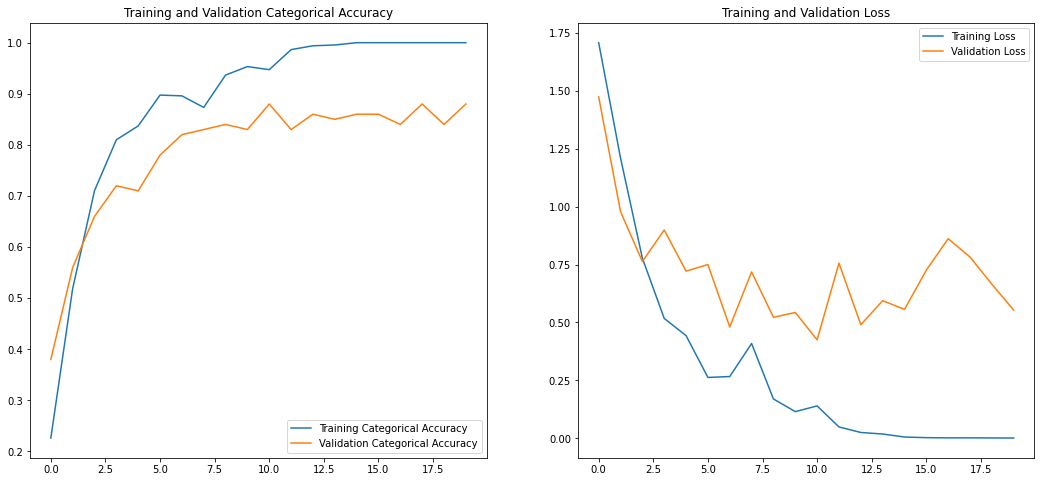

In [28]:
# plot performance parameters
conv_3d_1.plot_model_results(conv_3d_1_history)

We can still observe overfitting in the model even with a dropout layer. Trying with a higher dropouts and augmented data.
#### Model 2
Model with batch size 20, epochs 20, sample frames 20 and 120x120 image resolution. <br>
Using a dropout layer (0.25) in both CNN and Dense layers to prevent overfitting from base model.

In [29]:
class Conv3D2Model(BaseModelBuilder):
    """First 3D convolution model"""
    def construct_model(self, filter_size=(3,3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(Conv3D(16, filter_size, input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        ), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

In [30]:
# creating model
conv_3d_2 = Conv3D2Model(image_height=120, image_width=120)
conv_3d_2.initialize_project_path(project_folder)
conv_3d_2.tune_hyper_parameters(epochs=20, batch_size=20, sample_frames=20)
conv_3d_2.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 20
# 3D Tensor = (120, 120, 3)


In [31]:
# compile the model and show model summary
conv3d_model_2 = conv_3d_2.construct_model(dropout=0.25)
conv3d_model_2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_39 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_39 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_40 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 5, 30, 30, 64)   

In [32]:
# train the model
conv_3d_2_history = conv_3d_2.train_model(model=conv3d_model_2)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6959 - categorical_accuracy: 0.1931
Epoch 00001: val_loss improved from inf to 1.47687, saving model to model_init_2021-05-3010_13_13.240454/model-00001-1.69587-0.19306-1.47687-0.31000.h5
34/34 [==============================] - 67s 2s/step - loss: 1.6959 - categorical_accuracy: 0.1931 - val_loss: 1.4769 - val_categorical_accuracy: 0.3100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2149 - categorical_accuracy: 0.4992
Epoch 00002: val_loss improved from 1.47687 to 0.98951, saving model to model_init_2021-05-3010_13_13.240454/model-00002-1.21490-0.49925-0.98951-0.57000.h5
34/34 [==============================] - 67s 2s/step - loss: 1.2149 - categorical_accuracy: 0.4992 - val_loss: 0.9895 - val_categorical_accuracy: 0.5700
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8872 - categorical_accuracy: 0.6802
Epoch 00003: val_loss improved from 0.98951 to 0.77561, saving model

We can observe overfitting has slightly reduced in the model with 2 dropout layer. We can see that val_loss did not improve from 0.33799 so earlystopping stops the epoch automatically. Trying the same model with augmented data.

In [34]:
# creating model
conv_3d_2a = Conv3D2Model(image_height=120, image_width=120)
conv_3d_2a.initialize_project_path(project_folder)
conv_3d_2a.tune_hyper_parameters(epochs=20, batch_size=20, sample_frames=20)
conv3d_model_2a = conv_3d_2a.construct_model(dropout=0.25)
conv_3d_2a_history = conv_3d_2a.train_model(model=conv3d_model_2a, augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6164 - categorical_accuracy: 0.2315
Epoch 00001: val_loss improved from inf to 1.54403, saving model to model_init_2021-05-3010_37_08.300252/model-00001-1.61640-0.23152-1.54403-0.23000.h5
34/34 [==============================] - 111s 3s/step - loss: 1.6164 - categorical_accuracy: 0.2315 - val_loss: 1.5440 - val_categorical_accuracy: 0.2300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5221 - categorical_accuracy: 0.3122
Epoch 00002: val_loss improved from 1.54403 to 1.42493, saving model to model_init_2021-05-3010_37_08.300252/model-00002-1.52207-0.31222-1.42493-0.50000.h5
34/34 [==============================] - 116s 3s/step - loss: 1.5221 - categorical_accuracy: 0.3122 - val_loss: 1.4249 - val_categorical_accuracy: 0.5000
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3438 - categorical_accuracy: 0.4751
Epoch 00003: val_loss improved from 1.42493 to 1.23941, saving mod

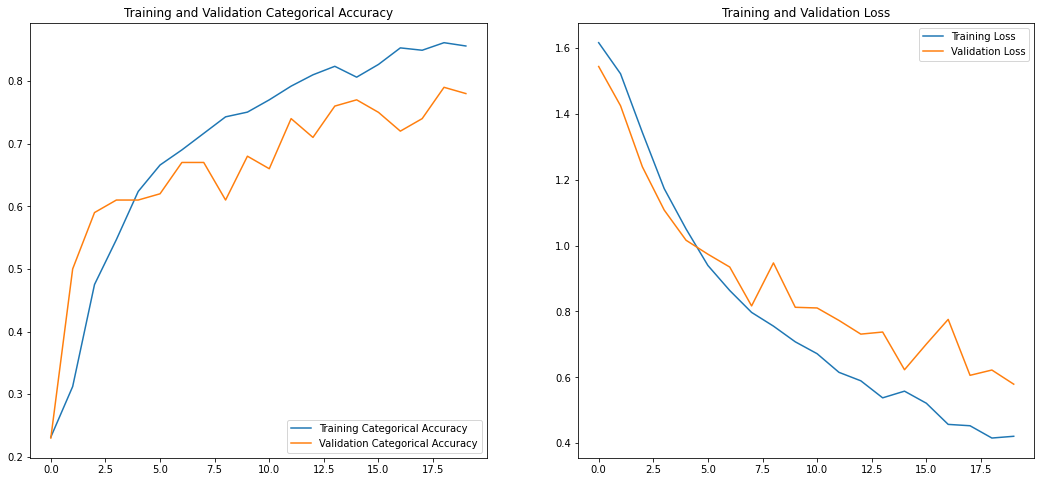

In [35]:
# plot performance parameters
conv_3d_2a.plot_model_results(conv_3d_2a_history)

The model has performed well with the best training accuracy of 85% and validation accuracy of 78%.
#### Model 3
Model with batch size 30, epochs 20, sample frames 20 and 120x120 image resolution and filter size of 2. <br>

In [36]:
class Conv3D3Model(BaseModelBuilder):
    """First 3D convolution model"""
    def construct_model(self, filter_size=(3,3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(Conv3D(16, filter_size, input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        ), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

In [37]:
# creating model
conv_3d_3 = Conv3D3Model(image_height=120, image_width=120)
conv_3d_3.initialize_project_path(project_folder)
conv_3d_3.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=20)
conv_3d_3.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 30
# 3D Tensor = (120, 120, 3)


In [39]:
# compile the model and show model summary
conv3d_model_3 = conv_3d_3.construct_model(filter_size=(2, 2, 2), dropout=0.25)
conv3d_model_3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_45 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_46 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_46 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_47 (Conv3D)           (None, 5, 30, 30, 64)   

In [40]:
# train the model
conv_3d_3_history = conv_3d_3.train_model(model=conv3d_model_3)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.9034 - categorical_accuracy: 0.2127
Epoch 00001: val_loss improved from inf to 1.58575, saving model to model_init_2021-05-3011_34_09.176478/model-00001-1.90338-0.21267-1.58575-0.26000.h5
23/23 [==============================] - 62s 3s/step - loss: 1.9034 - categorical_accuracy: 0.2127 - val_loss: 1.5857 - val_categorical_accuracy: 0.2600
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5268 - categorical_accuracy: 0.3092
Epoch 00002: val_loss improved from 1.58575 to 1.35763, saving model to model_init_2021-05-3011_34_09.176478/model-00002-1.52679-0.30920-1.35763-0.56000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.5268 - categorical_accuracy: 0.3092 - val_loss: 1.3576 - val_categorical_accuracy: 0.5600
Epoch 3/20
22/23 [===========================>..] - ETA: 2s - loss: 1.1703 - categorical_accuracy: 0.5091
Epoch 00003: val_loss improved from 1.35763 to 1.06295, saving model

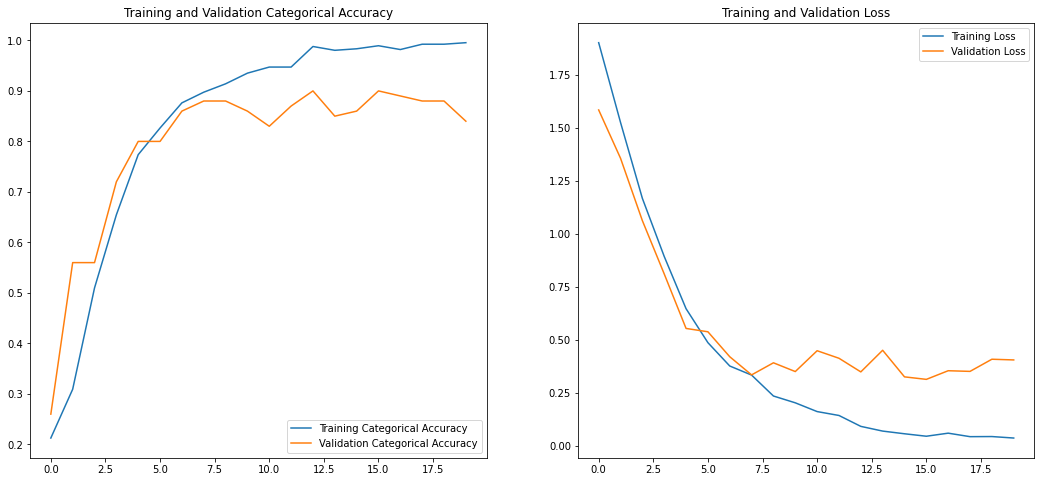

In [41]:
# plot performance parameters
conv_3d_3.plot_model_results(conv_3d_3_history)

The model has slightly overfitted again.
#### Model 4
Model with batch size 20, epochs 20, sample frames 20 and 120x120 image resolution. Also adding an extra convolution layer. <br>

In [42]:
class Conv3D4Model(BaseModelBuilder):
    """First 3D convolution model"""
    def construct_model(self, filter_size=(3,3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(Conv3D(16, filter_size, input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        ), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

In [43]:
# creating model
conv_3d_4 = Conv3D4Model(image_height=120, image_width=120)
conv_3d_4.initialize_project_path(project_folder)
conv_3d_4.tune_hyper_parameters(epochs=20, batch_size=20, sample_frames=20)
conv_3d_4.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 20
# 3D Tensor = (120, 120, 3)


In [44]:
# compile the model and show model summary
conv3d_model_4 = conv_3d_4.construct_model(dropout=0.25)
conv3d_model_4.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_49 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 5, 30, 30, 64)   

In [45]:
# train the model
conv_3d_4_history = conv_3d_4.train_model(model=conv3d_model_4, augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6183 - categorical_accuracy: 0.2225
Epoch 00001: val_loss improved from inf to 1.60716, saving model to model_init_2021-05-3012_15_57.161355/model-00001-1.61834-0.22247-1.60716-0.40000.h5
34/34 [==============================] - 106s 3s/step - loss: 1.6183 - categorical_accuracy: 0.2225 - val_loss: 1.6072 - val_categorical_accuracy: 0.4000
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5898 - categorical_accuracy: 0.2270
Epoch 00002: val_loss improved from 1.60716 to 1.58196, saving model to model_init_2021-05-3012_15_57.161355/model-00002-1.58979-0.22700-1.58196-0.38000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.5898 - categorical_accuracy: 0.2270 - val_loss: 1.5820 - val_categorical_accuracy: 0.3800
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5263 - categorical_accuracy: 0.3273
Epoch 00003: val_loss improved from 1.58196 to 1.54311, saving mod

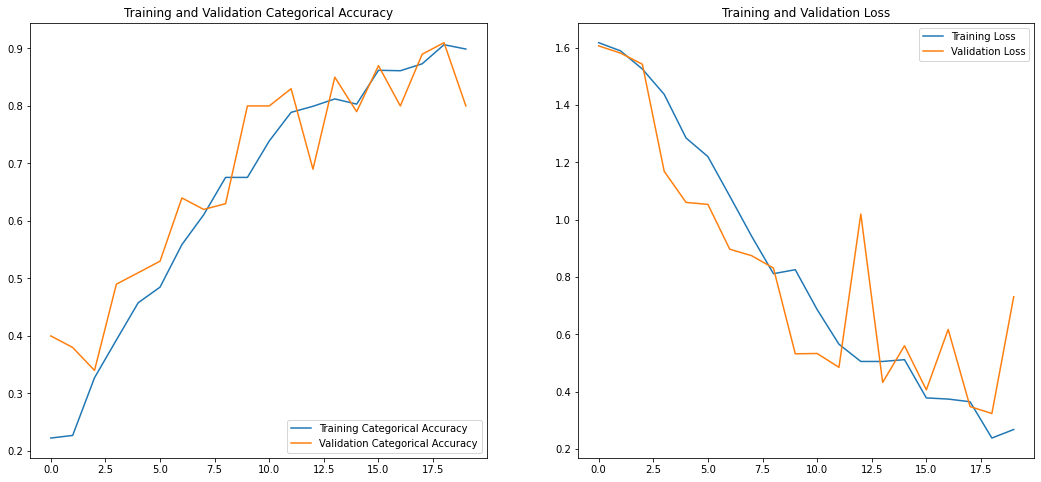

In [46]:
# plot performance parameters
conv_3d_4.plot_model_results(conv_3d_4_history)

The model has has performed significantly well however the validation accuracy is bit erratic.
#### Model 5
Model with batch size 20, epochs 20, sample frames 20 and 120x120 image resolution. Also adding an extra dense layer. <br>

In [55]:
class Conv3D5Model(BaseModelBuilder):
    """First 3D convolution model"""
    def construct_model(self, filter_size=(3,3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(Conv3D(16, filter_size, input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        ), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

In [56]:
# creating model
conv_3d_5 = Conv3D5Model(image_height=120, image_width=120)
conv_3d_5.initialize_project_path(project_folder)
conv_3d_5.tune_hyper_parameters(epochs=20, batch_size=20, sample_frames=20)
conv_3d_5.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 20
# 3D Tensor = (120, 120, 3)


In [57]:
# compile the model and show model summary
conv3d_model_5 = conv_3d_5.construct_model(dropout=0.25)
conv3d_model_5.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_60 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_60 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_61 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 5, 30, 30, 64)   

In [58]:
# train the model
conv_3d_5_history = conv_3d_5.train_model(model=conv3d_model_5, augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6132 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.54230, saving model to model_init_2021-05-3013_39_59.779673/model-00001-1.61319-0.20664-1.54230-0.23000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.6132 - categorical_accuracy: 0.2066 - val_loss: 1.5423 - val_categorical_accuracy: 0.2300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5994 - categorical_accuracy: 0.2308
Epoch 00002: val_loss did not improve from 1.54230
34/34 [==============================] - 102s 3s/step - loss: 1.5994 - categorical_accuracy: 0.2308 - val_loss: 1.5926 - val_categorical_accuracy: 0.2400
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5020 - categorical_accuracy: 0.3575
Epoch 00003: val_loss improved from 1.54230 to 1.22113, saving model to model_init_2021-05-3013_39_59.779673/model-00003-1.50196-0.35747-1.22113-0.42000.h5
34/34 [========

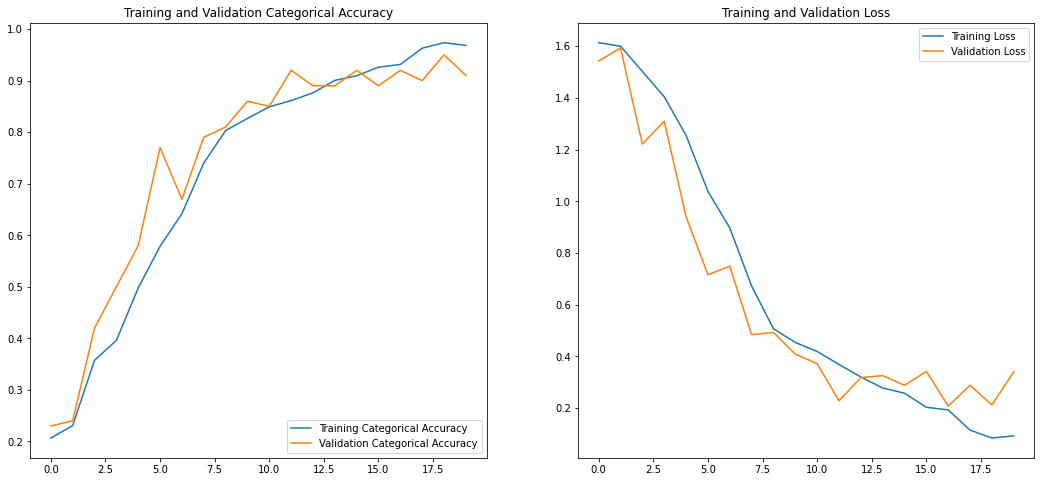

In [59]:
# plot performance parameters
conv_3d_5.plot_model_results(conv_3d_5_history)

#### Results and Observations
The ___Top 3 best performing 3D convolution models___ are listed below:
##### Model 5
- Model 5 __`Conv3D5Model`__ was the best performing model so far with a best _training accuracy of 96.8% and validation accuracy of 91%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 93% and validation accuracy of 92%__.
- This Model was built on a batch size of 20, epochs 20, sample frames 20 and 120x120 image resolution with data augmentation.
- Model was built on 4 CNN and 2 Dense with 2 Dropout layers.

##### Model 4
- Model 4 __`Conv3D4Model`__ was the  2nd best performing model with a _training accuracy of 89% and validation accuracy of 80%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 90% and validation accuracy of 91%__.
- This Model was built on a batch size of 20, epochs 20, sample frames 20 and 120x120 image resolution with data augmentation.
- Model was built on 4 CNN with 1 dropout and 1 Dense with 1 dropout layers.

##### Model 2
- Model 2 __`Conv3D2Model`__ was the  3rd best performing model with a _training accuracy of 85.6% and validation accuracy of 78%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 85.6% and validation accuracy of 78%__.
- This Model was built on a batch size of 20, epochs 20, sample frames 20 and 120x120 image resolution with data augmentation.
- Model was built on 3 CNN and 1 Dense with 1 Dropout layers.

## CNN + RNN Model

#### Base Model
##### Creating a Base Model with 30 batches of data and 10 epochs without resizing images and no sampling (use all frames).

In [25]:
class CNN_RNN_ModelBase(BaseModelBuilder):
    """First/Base CNN RNN model"""
    def construct_model(self, gru_cells=16, filter_size=(3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, filter_size, padding='same'), input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        )))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Conv2D(32, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))

        model.add(Dense(128, activation='relu'))

        model.add(Dense(self.num_classes, activation='softmax'))
        self.compile_model(model, optimizer)
        return model

In [13]:
# creating base model
cnn_rnn_base_model = CNN_RNN_ModelBase(image_height=160, image_width=160)
cnn_rnn_base_model.initialize_project_path(project_folder)
cnn_rnn_base_model.tune_hyper_parameters(epochs=10, batch_size=30, sample_frames=30)
cnn_rnn_base_model.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 160
# Image Width = 160
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 30
# epochs = 10
# Batch Size = 30
# 3D Tensor = (160, 160, 3)


In [14]:
# compile the model and show model summary
cnn_rnn_base_model_1 = cnn_rnn_base_model.construct_model()
cnn_rnn_base_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 30, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 160, 160, 16)  0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 80, 80, 32)    2080      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 80, 80, 32)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 40, 40, 64)   

In [15]:
# train the model
cnn_rnn_base_history = cnn_rnn_base_model.train_model(model=cnn_rnn_base_model_1)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.5875 - categorical_accuracy: 0.2549
Epoch 00001: val_loss improved from inf to 1.51400, saving model to model_init_2021-05-3105_09_57.966179/model-00001-1.58753-0.25490-1.51400-0.29000.h5
23/23 [==============================] - 95s 4s/step - loss: 1.5875 - categorical_accuracy: 0.2549 - val_loss: 1.5140 - val_categorical_accuracy: 0.2900
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.3955 - categorical_accuracy: 0.4389
Epoch 00002: val_loss improved from 1.51400 to 1.29651, saving model to model_init_2021-05-3105_09_57.966179/model-00002-1.39549-0.43891-1.29651-0.41000.h5
23/23 [==============================] - 98s 4s/step - loss: 1.3955 - categorical_accuracy: 0.4389 - val_loss: 1.2965 - val_categorical_accuracy: 0.4100
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.0839 - categorical_accuracy: 0.6214
Epoch 00003: val_loss improved from 1.29651 to 1.20208, saving model

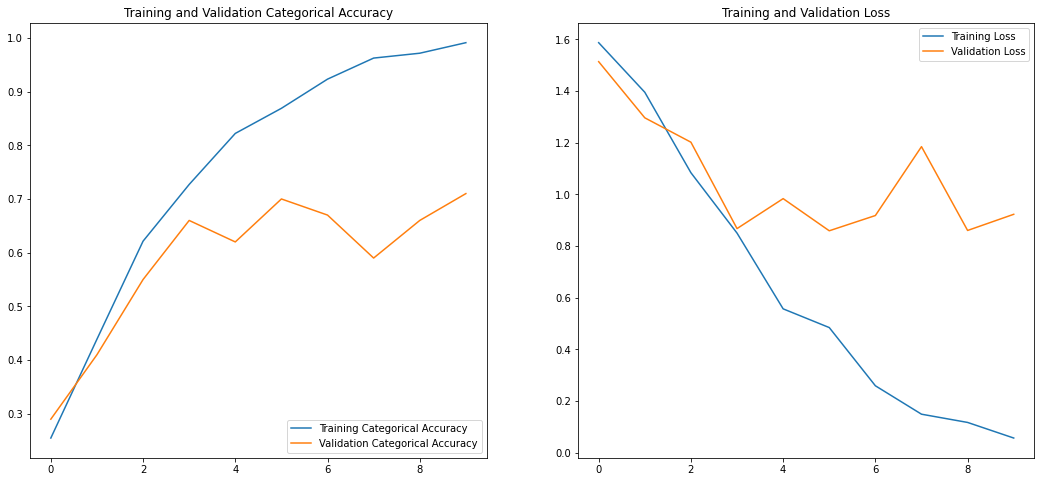

In [16]:
# plot base model performance
cnn_rnn_base_model.plot_model_results(cnn_rnn_base_history)

We can observe that the base model is __overfitting__. We can try out different combinations of image properties, hyperparameter tuning and batch sizes and select those having high impact to the models.
##### Experimenting with Hyperparameters

In [17]:
# Model A - sample frames to 16 and batch size 30 and no change in image properties and NO augmentation
cnn_rnn_exp_1 = CNN_RNN_ModelBase(image_height=160, image_width=160)
cnn_rnn_exp_1.initialize_project_path(project_folder)
cnn_rnn_exp_1.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=16)
cnn_rnn_exp_model_1 = cnn_rnn_exp_1.construct_model()
cnn_rnn_exp_1.train_model(model=cnn_rnn_exp_model_1)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.6016 - categorical_accuracy: 0.2564
Epoch 00001: val_loss improved from inf to 1.54571, saving model to model_init_2021-05-3105_26_29.585491/model-00001-1.60155-0.25641-1.54571-0.29000.h5
23/23 [==============================] - 51s 2s/step - loss: 1.6016 - categorical_accuracy: 0.2564 - val_loss: 1.5457 - val_categorical_accuracy: 0.2900
Epoch 2/5
22/23 [===========================>..] - ETA: 1s - loss: 1.4645 - categorical_accuracy: 0.3894
Epoch 00002: val_loss improved from 1.54571 to 1.37098, saving model to model_init_2021-05-3105_26_29.585491/model-00002-1.46384-0.38914-1.37098-0.51000.h5
23/23 [==============================] - 52s 2s/step - loss: 1.4638 - categorical_accuracy: 0.3891 - val_loss: 1.3710 - val_categorical_accuracy: 0.5100
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.2542 - categorical_accuracy: 0.5913
Epoch 00003: val_loss improved from 1.37098 to 1.19439, saving model to

In [18]:
# Model B- batch size 30, Image resized to 120x120, use all frames and NO augmentation
cnn_rnn_exp_2 = CNN_RNN_ModelBase(image_height=120, image_width=120)
cnn_rnn_exp_2.initialize_project_path(project_folder)
cnn_rnn_exp_2.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=30)
cnn_rnn_exp_model_2 = cnn_rnn_exp_2.construct_model()
cnn_rnn_exp_2.train_model(model=cnn_rnn_exp_model_2)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.6038 - categorical_accuracy: 0.2293
Epoch 00001: val_loss improved from inf to 1.57524, saving model to model_init_2021-05-3105_31_17.163378/model-00001-1.60381-0.22926-1.57524-0.22000.h5
23/23 [==============================] - 85s 4s/step - loss: 1.6038 - categorical_accuracy: 0.2293 - val_loss: 1.5752 - val_categorical_accuracy: 0.2200
Epoch 2/5
22/23 [===========================>..] - ETA: 3s - loss: 1.5518 - categorical_accuracy: 0.3136
Epoch 00002: val_loss improved from 1.57524 to 1.48053, saving model to model_init_2021-05-3105_31_17.163378/model-00002-1.55195-0.31373-1.48053-0.41000.h5
23/23 [==============================] - 85s 4s/step - loss: 1.5519 - categorical_accuracy: 0.3137 - val_loss: 1.4805 - val_categorical_accuracy: 0.4100
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.3982 - categorical_accuracy: 0.4796
Epoch 00003: val_loss improved from 1.48053 to 1.31317, saving model to

In [19]:
# Model C  - batch size 40, Image resized to 120x120, use all frames and NO augmentation
cnn_rnn_exp_3 = CNN_RNN_ModelBase(image_height=120, image_width=120)
cnn_rnn_exp_3.initialize_project_path(project_folder)
cnn_rnn_exp_3.tune_hyper_parameters(epochs=5, batch_size=40, sample_frames=30)
cnn_rnn_exp_model_3 = cnn_rnn_exp_3.construct_model()
cnn_rnn_exp_3.train_model(model=cnn_rnn_exp_model_3)

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.5979 - categorical_accuracy: 0.2594
Epoch 00001: val_loss improved from inf to 1.54088, saving model to model_init_2021-05-3105_39_53.599780/model-00001-1.59793-0.25943-1.54088-0.39000.h5
17/17 [==============================] - 85s 5s/step - loss: 1.5979 - categorical_accuracy: 0.2594 - val_loss: 1.5409 - val_categorical_accuracy: 0.3900
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.4414 - categorical_accuracy: 0.4630
Epoch 00002: val_loss improved from 1.54088 to 1.33152, saving model to model_init_2021-05-3105_39_53.599780/model-00002-1.44136-0.46305-1.33152-0.53000.h5
17/17 [==============================] - 85s 5s/step - loss: 1.4414 - categorical_accuracy: 0.4630 - val_loss: 1.3315 - val_categorical_accuracy: 0.5300
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.2241 - categorical_accuracy: 0.6003
Epoch 00003: val_loss improved from 1.33152 to 1.23708, saving model to

In [20]:
# Model D  - batch size 30, Image resized to 120x120, use all frames and augmentation
cnn_rnn_exp_4 = CNN_RNN_ModelBase(image_height=120, image_width=120)
cnn_rnn_exp_4.initialize_project_path(project_folder)
cnn_rnn_exp_4.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=30)
cnn_rnn_exp_model_4 = cnn_rnn_exp_4.construct_model()
cnn_rnn_exp_4.train_model(model=cnn_rnn_exp_model_4, augment_data=True)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.5939 - categorical_accuracy: 0.2406
Epoch 00001: val_loss improved from inf to 1.54463, saving model to model_init_2021-05-3105_47_23.117338/model-00001-1.59385-0.24057-1.54463-0.25000.h5
23/23 [==============================] - 160s 7s/step - loss: 1.5939 - categorical_accuracy: 0.2406 - val_loss: 1.5446 - val_categorical_accuracy: 0.2500
Epoch 2/5
22/23 [===========================>..] - ETA: 6s - loss: 1.5036 - categorical_accuracy: 0.3356 
Epoch 00002: val_loss improved from 1.54463 to 1.42374, saving model to model_init_2021-05-3105_47_23.117338/model-00002-1.50330-0.33635-1.42374-0.35000.h5
23/23 [==============================] - 157s 7s/step - loss: 1.5033 - categorical_accuracy: 0.3363 - val_loss: 1.4237 - val_categorical_accuracy: 0.3500
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.3730 - categorical_accuracy: 0.4630
Epoch 00003: val_loss improved from 1.42374 to 1.36387, saving model

In [21]:
# Model E - epoch 20, batch size 30, Image resized to 120x120, use all frames and NO augmentation
cnn_rnn_exp_5 = CNN_RNN_ModelBase(image_height=120, image_width=120)
cnn_rnn_exp_5.initialize_project_path(project_folder)
cnn_rnn_exp_5.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=30)
cnn_rnn_exp_model_5 = cnn_rnn_exp_5.construct_model()
cnn_rnn_exp_5.train_model(model=cnn_rnn_exp_model_5)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.5954 - categorical_accuracy: 0.2715
Epoch 00001: val_loss improved from inf to 1.50759, saving model to model_init_2021-05-3106_07_01.821306/model-00001-1.59541-0.27149-1.50759-0.39000.h5
23/23 [==============================] - 96s 4s/step - loss: 1.5954 - categorical_accuracy: 0.2715 - val_loss: 1.5076 - val_categorical_accuracy: 0.3900
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.3991 - categorical_accuracy: 0.4992
Epoch 00002: val_loss improved from 1.50759 to 1.33313, saving model to model_init_2021-05-3106_07_01.821306/model-00002-1.39915-0.49925-1.33313-0.53000.h5
23/23 [==============================] - 98s 4s/step - loss: 1.3991 - categorical_accuracy: 0.4992 - val_loss: 1.3331 - val_categorical_accuracy: 0.5300
Epoch 3/20
22/23 [===========================>..] - ETA: 3s - loss: 1.1913 - categorical_accuracy: 0.6000
Epoch 00003: val_loss improved from 1.33313 to 1.12076, saving model

In [23]:
# Model F - epoch 20, batch size 30, Image resized to 120x120, use all frames and augmentation
cnn_rnn_exp_5a = CNN_RNN_ModelBase(image_height=120, image_width=120)
cnn_rnn_exp_5a.initialize_project_path(project_folder)
cnn_rnn_exp_5a.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=30)
cnn_rnn_exp_model_5a = cnn_rnn_exp_5a.construct_model()
cnn_rnn_exp_5a.train_model(model=cnn_rnn_exp_model_5a, augment_data=True)

Epoch 1/20
22/23 [===========================>..] - ETA: 10s - loss: 1.6096 - categorical_accuracy: 0.2053
Epoch 00001: val_loss improved from inf to 1.59013, saving model to model_init_2021-05-3107_00_05.438873/model-00001-1.60916-0.20739-1.59013-0.23000.h5
23/23 [==============================] - 246s 11s/step - loss: 1.6092 - categorical_accuracy: 0.2074 - val_loss: 1.5901 - val_categorical_accuracy: 0.2300
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5813 - categorical_accuracy: 0.2247
Epoch 00002: val_loss improved from 1.59013 to 1.55421, saving model to model_init_2021-05-3107_00_05.438873/model-00002-1.58133-0.22474-1.55421-0.40000.h5
23/23 [==============================] - 188s 8s/step - loss: 1.5813 - categorical_accuracy: 0.2247 - val_loss: 1.5542 - val_categorical_accuracy: 0.4000
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5414 - categorical_accuracy: 0.3839
Epoch 00003: val_loss improved from 1.55421 to 1.50912, saving m

In [17]:
# Model G  - batch size 30, Image resized to 120x120, with 20 frames and NO augmentation
cnn_rnn_exp_8 = CNN_RNN_ModelBase(image_height=120, image_width=120)
cnn_rnn_exp_8.initialize_project_path(project_folder)
cnn_rnn_exp_8.tune_hyper_parameters(epochs=5, batch_size=30, sample_frames=20)
cnn_rnn_exp_model_8 = cnn_rnn_exp_8.construct_model()
cnn_rnn_exp_8.train_model(model=cnn_rnn_exp_model_8)

Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.5964 - categorical_accuracy: 0.2685
Epoch 00001: val_loss improved from inf to 1.50502, saving model to model_init_2021-05-3114_08_20.448360/model-00001-1.59639-0.26848-1.50502-0.36000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.5964 - categorical_accuracy: 0.2685 - val_loss: 1.5050 - val_categorical_accuracy: 0.3600
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.3502 - categorical_accuracy: 0.5158
Epoch 00002: val_loss improved from 1.50502 to 1.33999, saving model to model_init_2021-05-3114_08_20.448360/model-00002-1.35023-0.51584-1.33999-0.52000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.3502 - categorical_accuracy: 0.5158 - val_loss: 1.3400 - val_categorical_accuracy: 0.5200
Epoch 3/5
22/23 [===========================>..] - ETA: 2s - loss: 1.0561 - categorical_accuracy: 0.6424
Epoch 00003: val_loss improved from 1.33999 to 1.17671, saving model to

We can observe from the above experiments that `image resolution` and `number of frames` in sequence have __more impact__ on training time than batch_size. We can consider the batch size around 20-40 and change the resolution between 100x100 or 120x120 according the model performance.

### Model 1
- Model with batch size 30, epochs 20, sample frames 20 and 120x120 image resolution and NO augemented data.
- Adding 1 more CNN Layers
- Adding a dropout after RNN layer

In [36]:
class CNN_RNN1_Model(BaseModelBuilder):
    """First/Base CNN RNN model"""
    def construct_model(self, gru_cells=16, filter_size=(3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, filter_size, padding='same'), input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        )))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Conv2D(32, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(128, activation='relu'))

        model.add(Dense(self.num_classes, activation='softmax'))
        
        self.compile_model(model, optimizer)
        return model

In [19]:
# creating model 1
cnn_rnn_1 = CNN_RNN1_Model(image_height=120, image_width=120)
cnn_rnn_1.initialize_project_path(project_folder)
cnn_rnn_1.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=20)
cnn_rnn_1.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 30
# 3D Tensor = (120, 120, 3)


In [20]:
# compile the model and show model summary
cnn_rnn_1_model = cnn_rnn_1.construct_model(dropout=0.25)
cnn_rnn_1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 60, 60, 32)    2080      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 30, 30, 64)   

In [21]:
# train the model
cnn_rnn_1_history = cnn_rnn_1.train_model(model=cnn_rnn_1_model)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6071 - categorical_accuracy: 0.1976
Epoch 00001: val_loss improved from inf to 1.58427, saving model to model_init_2021-05-3114_14_14.531311/model-00001-1.60712-0.19759-1.58427-0.24000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.6071 - categorical_accuracy: 0.1976 - val_loss: 1.5843 - val_categorical_accuracy: 0.2400
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5364 - categorical_accuracy: 0.2896
Epoch 00002: val_loss improved from 1.58427 to 1.40580, saving model to model_init_2021-05-3114_14_14.531311/model-00002-1.53641-0.28959-1.40580-0.42000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.5364 - categorical_accuracy: 0.2896 - val_loss: 1.4058 - val_categorical_accuracy: 0.4200
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.3561 - categorical_accuracy: 0.4238
Epoch 00003: val_loss improved from 1.40580 to 1.26903, saving model

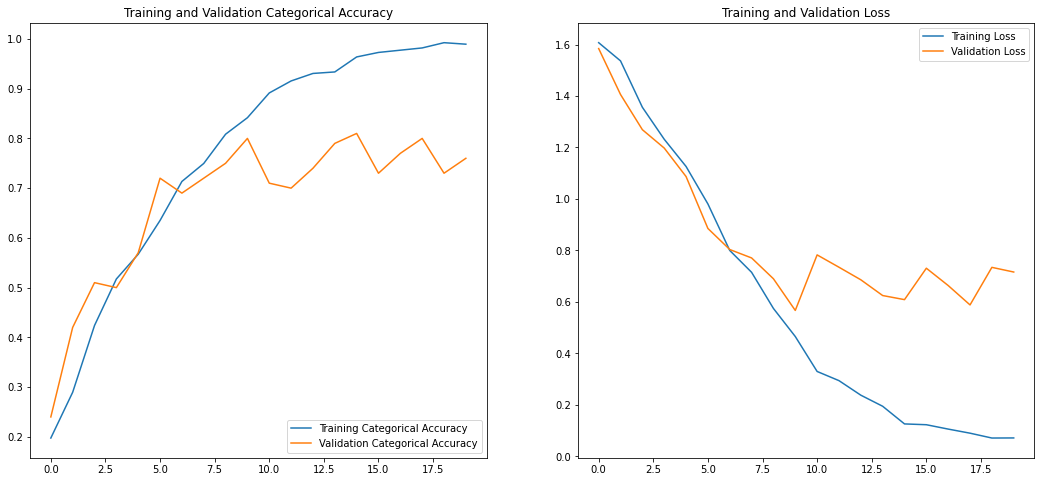

In [22]:
# plot model performance
cnn_rnn_1.plot_model_results(cnn_rnn_1_history)

We can still observe overfitting in the model even with a dropout layer

### Model 2 
- Model with batch size 30, epochs 20, sample frames 30 and 120x120 image resolution and NO augemented data.
- Adding a dropout after RNN layer and after dense layer

In [35]:
class CNN_RNN2_Model(BaseModelBuilder):
    """First/Base CNN RNN model"""
    def construct_model(self, gru_cells=16, filter_size=(3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, filter_size, padding='same'), input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        )))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Conv2D(32, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        
        self.compile_model(model, optimizer)
        return model

In [25]:
# creating model 2
cnn_rnn_2 = CNN_RNN2_Model(image_height=120, image_width=120)
cnn_rnn_2.initialize_project_path(project_folder)
cnn_rnn_2.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=20)
cnn_rnn_2.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 30
# 3D Tensor = (120, 120, 3)


In [26]:
# compile the model and show model summary
cnn_rnn_2_model = cnn_rnn_2.construct_model(dropout=0.25)
cnn_rnn_2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 60, 60, 32)    2080      
_________________________________________________________________
time_distributed_40 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 20, 30, 30, 64)   

In [27]:
# train the model
cnn_rnn_2_history = cnn_rnn_2.train_model(model=cnn_rnn_2_model)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.2051
Epoch 00001: val_loss improved from inf to 1.57648, saving model to model_init_2021-05-3114_35_01.393971/model-00001-1.60462-0.20513-1.57648-0.25000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.6046 - categorical_accuracy: 0.2051 - val_loss: 1.5765 - val_categorical_accuracy: 0.2500
Epoch 2/20
22/23 [===========================>..] - ETA: 2s - loss: 1.5758 - categorical_accuracy: 0.2652
Epoch 00002: val_loss improved from 1.57648 to 1.53525, saving model to model_init_2021-05-3114_35_01.393971/model-00002-1.57600-0.26395-1.53525-0.39000.h5
23/23 [==============================] - 59s 3s/step - loss: 1.5760 - categorical_accuracy: 0.2640 - val_loss: 1.5352 - val_categorical_accuracy: 0.3900
Epoch 3/20
22/23 [===========================>..] - ETA: 2s - loss: 1.4688 - categorical_accuracy: 0.3894
Epoch 00003: val_loss improved from 1.53525 to 1.30184, saving model

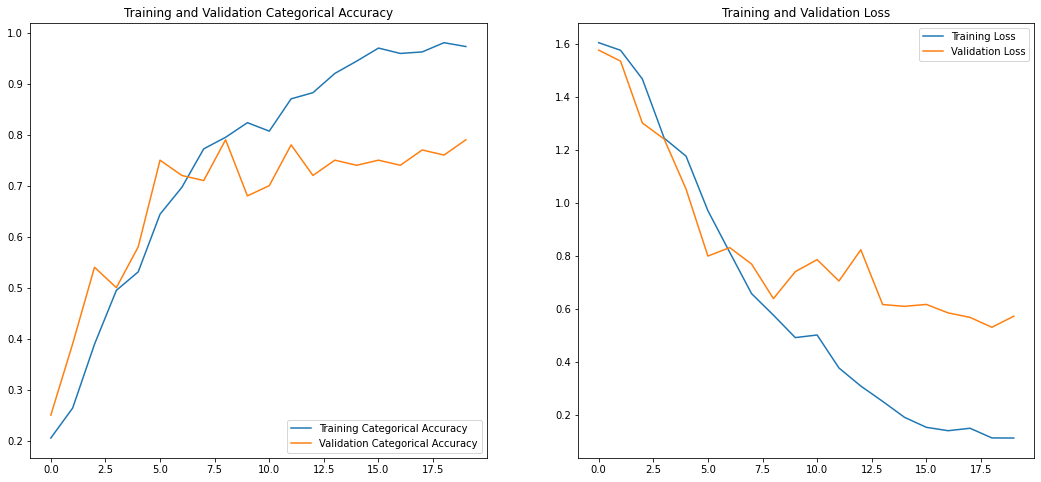

In [28]:
# plot model performance
cnn_rnn_2.plot_model_results(cnn_rnn_2_history)

We can still observe overfitting in the model even with a two dropout layer. 

### Model 3
- Model with batch size 30, epochs 20, sample frames 30 and 120x120 image resolution and NO augemented data.
- Adding one more dense layer
- Adding a dropout after each Dense Layer

In [40]:
class CNN_RNN3_Model(BaseModelBuilder):
    """First/Base CNN RNN model"""
    def construct_model(self, gru_cells=16, filter_size=(3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, filter_size, padding='same'), input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        )))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Conv2D(32, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells, activation='relu'))

        model.add(Dense(256, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        self.compile_model(model, optimizer)
        return model

In [31]:
# creating model 3
cnn_rnn_3 = CNN_RNN3_Model(image_height=120, image_width=120)
cnn_rnn_3.initialize_project_path(project_folder)
cnn_rnn_3.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=20)
cnn_rnn_3.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 30
# 3D Tensor = (120, 120, 3)


In [33]:
# compile the model and show model summary
cnn_rnn_3_model = cnn_rnn_3.construct_model(dropout=0.25)
cnn_rnn_3_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_62 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_63 (TimeDis (None, 20, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 20, 60, 60, 32)    2080      
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 20, 30, 30, 64)   

In [34]:
# train the model
cnn_rnn_3_history = cnn_rnn_3.train_model(model=cnn_rnn_3_model)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6065 - categorical_accuracy: 0.2066
Epoch 00001: val_loss improved from inf to 1.58110, saving model to model_init_2021-05-3114_57_53.803801/model-00001-1.60652-0.20664-1.58110-0.31000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.6065 - categorical_accuracy: 0.2066 - val_loss: 1.5811 - val_categorical_accuracy: 0.3100
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5357 - categorical_accuracy: 0.2881
Epoch 00002: val_loss improved from 1.58110 to 1.51855, saving model to model_init_2021-05-3114_57_53.803801/model-00002-1.53573-0.28808-1.51855-0.35000.h5
23/23 [==============================] - 59s 3s/step - loss: 1.5357 - categorical_accuracy: 0.2881 - val_loss: 1.5185 - val_categorical_accuracy: 0.3500
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.3972 - categorical_accuracy: 0.3831
Epoch 00003: val_loss improved from 1.51855 to 1.32455, saving model

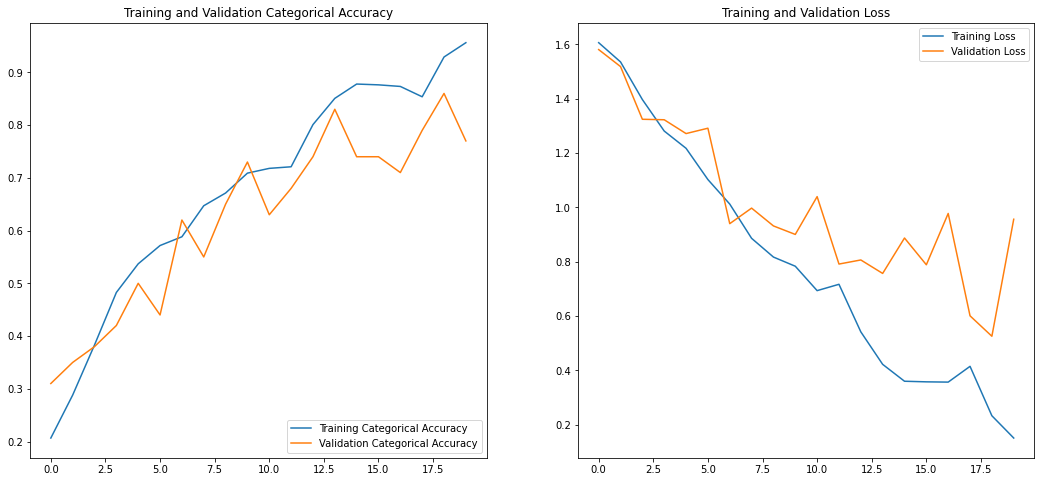

In [37]:
# plot model performance
cnn_rnn_3.plot_model_results(cnn_rnn_3_history)

The model has has performed significantly well for 19th epoch

### Model 4
- Model with batch size 30, epochs 20, sample frames 30 and 120x120 image resolution and NO augemented data.
- Adding one CNN Layer

In [17]:
class CNN_RNN4_Model(BaseModelBuilder):
    """First/Base CNN RNN model"""
    def construct_model(self, gru_cells=16, filter_size=(3,3), dropout=0.5, optimizer=optimizers.Adam()):
        """Method to construct the conv3D model"""
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, filter_size, padding='same'), input_shape=(
            self.frames_to_sample, self.image_height, self.image_width, self.num_channels
        )))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Conv2D(32, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (2,2), padding='same')))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells, activation='relu'))

        model.add(Dense(256, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        self.compile_model(model, optimizer)
        return model

In [18]:
# creating model 4
cnn_rnn_4 = CNN_RNN4_Model(image_height=120, image_width=120)
cnn_rnn_4.initialize_project_path(project_folder)
cnn_rnn_4.tune_hyper_parameters(epochs=20, batch_size=30, sample_frames=20)
cnn_rnn_4.__show_param_details__()

================= Project Folder ================= 

# training sequences = 663
# validation sequences = 100 

================ Image Properties ================ 

# Image Height = 120
# Image Width = 120
# Channels = 3
# Output Classes = 5
# Total Frames = 30 

================ Hyperparameters ================= 

# Number of Frames to sample = 20
# epochs = 20
# Batch Size = 30
# 3D Tensor = (120, 120, 3)


In [19]:
# compile the model and show model summary
cnn_rnn_4_model = cnn_rnn_4.construct_model(dropout=0.25)
cnn_rnn_4_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_30 (TimeDis (None, 20, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 20, 60, 60, 32)    2080      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 20, 30, 30, 64)   

In [20]:
# train the model
cnn_rnn_4_history = cnn_rnn_4.train_model(model=cnn_rnn_4_model)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.1840
Epoch 00001: val_loss improved from inf to 1.60124, saving model to model_init_2021-05-3115_39_28.944579/model-00001-1.61030-0.18401-1.60124-0.18000.h5
23/23 [==============================] - 59s 3s/step - loss: 1.6103 - categorical_accuracy: 0.1840 - val_loss: 1.6012 - val_categorical_accuracy: 0.1800
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5904 - categorical_accuracy: 0.2413
Epoch 00002: val_loss improved from 1.60124 to 1.57838, saving model to model_init_2021-05-3115_39_28.944579/model-00002-1.59037-0.24133-1.57838-0.20000.h5
23/23 [==============================] - 58s 3s/step - loss: 1.5904 - categorical_accuracy: 0.2413 - val_loss: 1.5784 - val_categorical_accuracy: 0.2000
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.4905 - categorical_accuracy: 0.3560
Epoch 00003: val_loss improved from 1.57838 to 1.39696, saving model

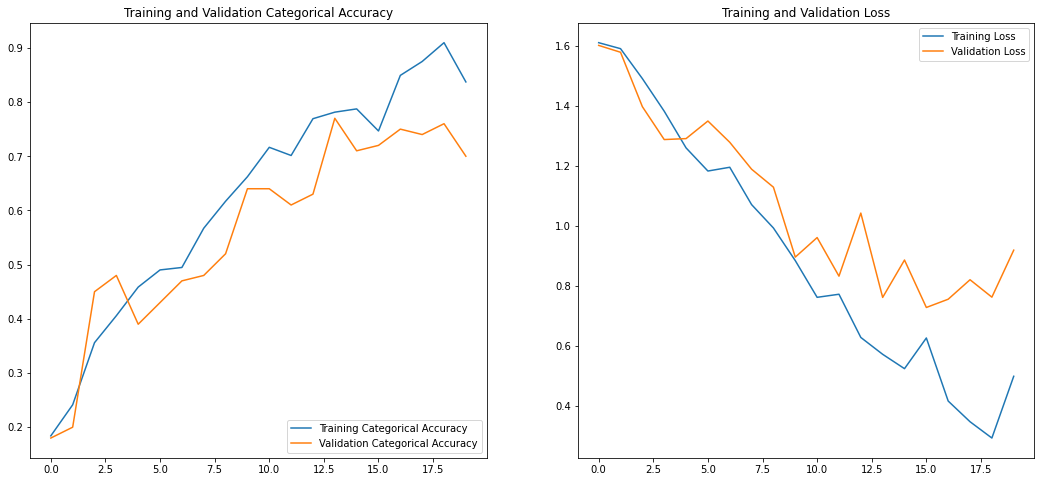

In [29]:
# plot model performance
cnn_rnn_4.plot_model_results(cnn_rnn_4_history)

The model has has performed significantly reduce overfitting but the accuracy is also reduced.

## Final Observations
### Conv3D - Results and Observations
The ___Top 3 best performing 3D convolution models___ are listed below:
##### Model 5
- Model 5 __`Conv3D5Model`__ was the best performing model so far with a best _training accuracy of 96.8% and validation accuracy of 91%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 93% and validation accuracy of 92%__.
- This Model was built on a batch size of 20, epochs 20, sample frames 20 and 120x120 image resolution with data augmentation.
- Model was built on 4 CNN and 2 Dense with 2 Dropout layers.

##### Model 4
- Model 4 __`Conv3D4Model`__ was the  2nd best performing model with a _training accuracy of 89% and validation accuracy of 80%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 90% and validation accuracy of 91%__.
- This Model was built on a batch size of 20, epochs 20, sample frames 20 and 120x120 image resolution with data augmentation.
- Model was built on 4 CNN with 1 dropout and 1 Dense with 1 dropout layers.

##### Model 2
- Model 2 __`Conv3D2Model`__ was the  3rd best performing model with a _training accuracy of 85.6% and validation accuracy of 78%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 85.6% and validation accuracy of 78%__.
- This Model was built on a batch size of 20, epochs 20, sample frames 20 and 120x120 image resolution with data augmentation.
- Model was built on 3 CNN and 1 Dense with 1 Dropout layers.

### CNN+RNN - Results and Observations
The ___Top 2 best performing CNN + RNN models___ are listed below:
##### Model 3
- Model 3 __`CNN_RNN3_Model`__ was the best performing model so far with a best _training accuracy of 95.65% and validation accuracy of 77%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 92% and validation accuracy of 86%__.
- This Model was built on a batch size of 30, epochs 20, sample frames 20 and 120x120 image resolution without data augmentation.
- Model was built on 4 CNN , 1 RNN GRU Layer and 2 Dense with 2 Dropout layers.

##### Model 4
- Model 4 __`CNN_RNN4_Model`__ was the  2nd best performing model with a _training accuracy of 83% and validation accuracy of 70%_ at last epoch.
- The best model saved based on the validation loss had a __training accuracy of 74% and validation accuracy of 72%__.
- This Model was built on a batch size of 30, epochs 20, sample frames 20 and 120x120 image resolution without data augmentation.
- Model was built on 5 CNN , 1 RNN GRU Layer and 2 Dense with 2 Dropout layers.

## Best Performing Model
- The 3D convolutional neural network __`Conv3D5Model`__ model with 4 convolution layers and 2 dense with accompanying dropout layers produced the best performing model using image properties like a resolution of 120x120, batch size of 20 and sampling frames of 20.
- This resulted in an overall __training accuracy of 96.8%__ and __validation accuracy of 91%__.